# Individual project

## Chenxin Xie

## 1. Set up  libraries

In [47]:
library(data.table)
library(dummies)
library(plyr)             
library(stringr)          
library(vita)             
library(dataPreparation)  
library(Boruta)          
library(mlr)         
library(caret)        
library(mlbench)       
library(randomForest) 
library(gbm)           
library(xgboost)
library(pls)
library(e1071)
library(gam)
library(bst)
library(mlrMBO)
library(parallel)
library(parallelMap)
library(DiceKriging)
library(rgenoud)
library(class)
library(kknn)

Warning message:
"package 'kknn' was built under R version 3.6.3"
Attaching package: 'kknn'

The following object is masked from 'package:caret':

    contr.dummy



In [46]:
# install.packages("kknn")

Installing package into 'C:/Users/cxie/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'kknn' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cxie\AppData\Local\Temp\RtmpeivT82\downloaded_packages


## 2. Data Preparation

### 2.1 Explore Data

#### Read and print out some data

In [2]:
train_full <- read.csv('C:/Users/cxie/Desktop/statistical/mbd2019-in-class-competition-bank-mkt/bank_mkt_train.csv') 
test <- read.csv('C:/Users/cxie/Desktop/statistical/mbd2019-in-class-competition-bank-mkt/bank_mkt_test.csv') 

In [3]:
# Print out to check the data type
str(train_full)

'data.frame':	7000 obs. of  21 variables:
 $ client_id     : int  2 3 4 5 6 7 8 9 14 15 ...
 $ age           : int  29 39 49 32 29 51 34 52 52 29 ...
 $ job           : Factor w/ 12 levels "admin.","blue-collar",..: 4 11 2 7 1 7 2 8 1 1 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 3 2 2 3 3 2 2 2 2 3 ...
 $ education     : Factor w/ 8 levels "basic.4y","basic.6y",..: 4 3 2 7 4 7 1 4 7 7 ...
 $ default       : Factor w/ 2 levels "no","unknown": 1 2 2 1 2 2 1 1 1 1 ...
 $ housing       : Factor w/ 3 levels "no","unknown",..: 1 3 1 3 3 3 3 3 3 3 ...
 $ loan          : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ contact       : Factor w/ 2 levels "cellular","telephone": 2 2 1 1 1 2 1 1 1 1 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 7 5 8 7 4 5 8 8 8 5 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 2 1 4 2 1 4 4 4 3 2 ...
 $ campaign      : int  3 6 2 3 2 1 1 1 3 1 ...
 $ pdays         : int  999 999 999 999 9

#### Check the target variable class distribution.

In [4]:
# By number
table(train_full$subscribe)


   0    1 
6178  822 

In [5]:
# By percentage
table(train_full$subscribe) / nrow(train_full)


        0         1 
0.8825714 0.1174286 

#### Check missing value

In [6]:
apply(is.na(train_full), 2, sum)

client_id            age            job        marital      education 
             0              0              0              0              0 
       default        housing           loan        contact          month 
             0              0              0              0              0 
   day_of_week       campaign          pdays       previous       poutcome 
             0              0              0              0              0 
  emp.var.rate cons.price.idx  cons.conf.idx      euribor3m    nr.employed 
             0              0              0              0              0 
     subscribe 
             0

### 2.2 Split Data into train and valid

In [3]:
# spiltting and resampling into train (70%) and valid (30%)
set.seed(1314)
trainIndex <- createDataPartition(train_full$subscribe, p = 0.7, list = FALSE, times = 1)
head(trainIndex)

Resample1
1
2
3
5
6
7


In [4]:
train <- train_full[trainIndex, ]
valid <- train_full[-trainIndex, ]

#### Check the target variable class distribution

In [9]:
# train
ddply(train, "subscribe", summarise, count = length(subscribe), 
    percentage = round(length(subscribe)/nrow(train), 2))

subscribe,count,percentage
0,4305,0.88
1,595,0.12


In [10]:
# vaild
ddply(valid, "subscribe", summarise, count = length(subscribe), 
    percentage = round(length(subscribe)/nrow(valid), 2))

subscribe,count,percentage
0,1873,0.89
1,227,0.11


#### find the important features

In [11]:
set.seed(2)
X <- train[, 2:(ncol(train)-1)]
y <- as.factor(train[, 'subscribe'])
# prepare training scheme
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
# train the model
results <- rfe(X, y,rfeControl=control)
# estimate variable importance
importance <- varImp(results, scale=FALSE)
# summarize importance
print(importance)

               Overall
euribor3m    15.070305
pdays        14.333073
nr.employed  13.658191
month        11.053390
education    10.198596
job           9.459365
poutcome      9.261856
age           9.153498
contact       8.765193
emp.var.rate  8.700949


check more information about the important features

In [12]:
summary(train$euribor3m)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.634   1.327   4.857   3.568   4.961   5.045 

In [16]:
summary(train$pdays)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   999.0   999.0   961.7   999.0   999.0 

In [13]:
summary(train$nr.employed)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4964    5099    5191    5165    5228    5228 

In [14]:
summary(train$poutcome)

failure nonexistent     success 
        505        4229         166

In [15]:
summary(train$month)

apr  aug  dec  jul  jun  mar  may  nov  oct  sep 
 316  731   21  838  638   75 1634  464  108   75

In [17]:
summary(train$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   32.00   38.00   40.44   48.00   98.00 

In [18]:
summary(train$education)

basic.4y            basic.6y            basic.9y         high.school 
                514                 246                 696                1126 
         illiterate professional.course   university.degree             unknown 
                  5                 632                1478                 203

In [19]:
summary(train$job)

admin.   blue-collar  entrepreneur     housemaid    management 
         1212          1062           178           133           373 
      retired self-employed      services       student    technician 
          221           183           459           106           816 
   unemployed       unknown 
          121            36

In [20]:
summary(train$contact)

cellular telephone 
     3125      1775

### 2.3 Create variables and dummies

#### Add dummies for 'poutcome'

In [5]:
train <- createDummyFeatures(train, cols = "poutcome")
valid <- createDummyFeatures(valid, cols = "poutcome")
test <- createDummyFeatures(test, cols = "poutcome")

#### Add dummies for 'job'

In [6]:
train <- createDummyFeatures(train, cols = "job")
valid <- createDummyFeatures(valid, cols = "job")
test <- createDummyFeatures(test, cols = "job")

#### Add variable 'pdays_999'

In [7]:
# Add new variable to train, valid and test
# median and max of pdays is 999
# Train, valid, test
train[, 'pdays_999'] <- ifelse(train$pdays == 999, 1, 0)
valid[, 'pdays_999'] <- ifelse(valid$pdays == 999, 1, 0)
test[, 'pdays_999'] <- ifelse(test$pdays == 999, 1, 0)

#### Add variable to gourp months into 4 seasons

In [8]:
# group month: March, April, May in "spring"
train[, 'spring'] <- ifelse(train$month %in% c('mar', 'apr', 'may'), 1, 0)
valid[, 'spring'] <- ifelse(valid$month %in% c('mar', 'apr', 'may'), 1, 0)
test[, 'spring'] <- ifelse(test$month %in% c('mar', 'apr', 'may'), 1, 0)

In [9]:
# group month:June, July, August in "summer"
train[, 'summer'] <- ifelse(train$month %in% c('jun', 'jul', 'aug'), 1, 0)
valid[, 'summer'] <- ifelse(valid$month %in% c('jun', 'jul', 'aug'), 1, 0)
test[, 'summer'] <- ifelse(test$month %in% c('jun', 'jul', 'aug'), 1, 0)

In [10]:
# group month: September, October, November in "fall"
train[, 'fall'] <- ifelse(train$month %in% c('sep', 'oct', 'nov'), 1, 0)
valid[, 'fall'] <- ifelse(valid$month %in% c('sep', 'oct', 'nov'), 1, 0)
test[, 'fall'] <- ifelse(test$month %in% c('sep', 'oct', 'nov'), 1, 0)

In [11]:
# group month: December, January, Februaryin "winter"
train[, 'winter'] <- ifelse(train$month %in% c('dec', 'jan', 'feb'), 1, 0)
valid[, 'winter'] <- ifelse(valid$month %in% c('dec', 'jan', 'feb'), 1, 0)
test[, 'winter'] <- ifelse(test$month %in% c('dec', 'jan', 'feb'), 1, 0)

In [12]:
#### Add varaible 'higher_education'
train[, 'higher_education'] <- ifelse(train$education %in% c('professional.course', 'university.degree'),1,0) 
valid[, 'higher_education'] <- ifelse(valid$education %in% c('professional.course', 'university.degree'),1,0) 
test[, 'higher_education'] <- ifelse(test$education %in% c('professional.course', 'university.degree'),1,0) 

#### Add variable: age_greater

In [13]:
# take age greater than median 38 as age_greater
train[, 'age_greater'] <- ifelse(train$age > 38, 1, 0)
valid[, 'age_greater'] <- ifelse(valid$age > 38, 1, 0)
test[, 'age_greater'] <- ifelse(test$age > 38, 1, 0)

#### add dummy variables for contact 

In [14]:
train[, 'contact_telephone'] <- ifelse(train$contact == 'telephone', 1, 0)
valid[, 'contact_telephone'] <- ifelse(valid$contact == 'telephone', 1, 0)
test[, 'contact_telephone'] <- ifelse(test$contact == 'telephone', 1, 0)

#### add dummy variables for marital, default, housing, loan, day_of_week

In [15]:
train <- createDummyFeatures(train, cols = "marital")
valid <- createDummyFeatures(valid, cols = "marital")
test <- createDummyFeatures(test, cols = "marital")

train <- createDummyFeatures(train, cols = "default")
valid <- createDummyFeatures(valid, cols = "default")
test <- createDummyFeatures(test, cols = "default")

train <- createDummyFeatures(train, cols = "housing")
valid <- createDummyFeatures(valid, cols = "housing")
test <- createDummyFeatures(test, cols = "housing")

train <- createDummyFeatures(train, cols = "loan")
valid <- createDummyFeatures(valid, cols = "loan")
test <- createDummyFeatures(test, cols = "loan")


train <- createDummyFeatures(train, cols = "day_of_week")
valid <- createDummyFeatures(valid, cols = "day_of_week")
test <- createDummyFeatures(test, cols = "day_of_week")

In [17]:
head(train)

,client_id,age,education,contact,month,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,housing.unknown,housing.yes,loan.no,loan.unknown,loan.yes,day_of_week.fri,day_of_week.mon,day_of_week.thu,day_of_week.tue,day_of_week.wed
1,2,29,high.school,telephone,may,3,999,0,1.1,93.994,...,0,0,1,0,0,0,1,0,0,0
2,3,39,basic.9y,telephone,jun,6,999,0,1.4,94.465,...,0,1,1,0,0,1,0,0,0,0
3,4,49,basic.6y,cellular,nov,2,999,0,-0.1,93.200,...,0,0,1,0,0,0,0,0,1,0
5,6,29,high.school,cellular,jul,2,999,0,1.4,93.918,...,0,1,1,0,0,1,0,0,0,0
6,7,51,university.degree,telephone,jun,1,999,0,1.4,94.465,...,0,1,1,0,0,0,0,0,1,0
7,8,34,basic.4y,cellular,nov,1,999,0,-0.1,93.200,...,0,1,1,0,0,0,0,0,1,0


### 2.4 Feature selection

FisherScore Reference:  
Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

#### Check missing values

In [16]:
# Train, valid, test
sum(apply(is.na(train), 2, sum))
sum(apply(is.na(valid), 2, sum))
sum(apply(is.na(test), 2, sum))

[1] 0

[1] 0

[1] 0

In [24]:
str(train)

'data.frame':	4900 obs. of  54 variables:
 $ client_id           : int  2 3 4 6 7 8 14 15 16 18 ...
 $ age                 : int  29 39 49 29 51 34 52 29 31 47 ...
 $ education           : Factor w/ 8 levels "basic.4y","basic.6y",..: 4 3 2 4 7 1 7 7 2 4 ...
 $ contact             : Factor w/ 2 levels "cellular","telephone": 2 2 1 1 2 1 1 1 1 2 ...
 $ month               : Factor w/ 10 levels "apr","aug","dec",..: 7 5 8 4 5 8 8 5 7 7 ...
 $ campaign            : int  3 6 2 2 1 1 3 1 1 1 ...
 $ pdays               : int  999 999 999 999 999 999 999 999 999 999 ...
 $ previous            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ emp.var.rate        : num  1.1 1.4 -0.1 1.4 1.4 -0.1 -0.1 -2.9 -1.8 1.1 ...
 $ cons.price.idx      : num  94 94.5 93.2 93.9 94.5 ...
 $ cons.conf.idx       : num  -36.4 -41.8 -42 -42.7 -41.8 -42 -42 -40.8 -46.2 -36.4 ...
 $ euribor3m           : num  4.86 4.96 4.15 4.96 4.86 ...
 $ nr.employed         : num  5191 5228 5196 5228 5228 ...
 $ subscribe           : int  0 0 0

In [17]:
# drop categorical variables
train[, c('education', 'contact', 'month')] <- NULL
valid[, c('education', 'contact', 'month')] <- NULL
test[, c('education', 'contact', 'month')] <- NULL

#### 2.4.2. Variable selection: Fisher Score

In [18]:
FisherScore <- function(basetable, depvar, IV_list) {

  # Get the unique values of dependent variable
  DV <- unique(basetable[, depvar])
  
  IV_FisherScore <- c()
  
  for (v in IV_list) {
    fs <- abs((mean(basetable[which(basetable[, depvar]==DV[1]), v]) - mean(basetable[which(basetable[, depvar]==DV[2]), v]))) /
      sqrt((var(basetable[which(basetable[, depvar]==DV[1]), v]) + var(basetable[which(basetable[, depvar]==DV[2]), v])))
    IV_FisherScore <- c(IV_FisherScore, fs)
  }
  
  return(data.frame(IV=IV_list, fisher_score=IV_FisherScore))
}

varSelectionFisher <- function(basetable, depvar, IV_list, num_select=20) {
  
  fs <- FisherScore(basetable, depvar, IV_list)  # Calculate Fisher Score for all IVs
  num_select <- min(num_select, ncol(basetable))  # Top N IVs to be selected
  return(as.vector(fs[order(fs$fisher_score, decreasing=T), ][1:num_select, 'IV']))
}

In [19]:
# Calculate Fisher Score for all variable
# Get the IV and DV list
dv_list <- c('subscribe')  # DV list
iv_list <- setdiff(names(train), dv_list)  # IV list excluded DV
iv_list <- setdiff(iv_list, 'client_id')  # Excluded the client_id
fs <- FisherScore(train, dv_list, iv_list)
head(fs)

IV,fisher_score
age,0.1004625
campaign,0.1624347
pdays,0.4525253
previous,0.3851976
emp.var.rate,0.6932537
cons.price.idx,0.3027802


In [20]:
# Select top 20 variables according to the Fisher Score
best_fs_var <- varSelectionFisher(train, dv_list, iv_list, num_select=20)
best_fs_var

[1] "nr.employed"          "euribor3m"            "emp.var.rate"        
 [4] "pdays_999"            "pdays"                "poutcome.success"    
 [7] "contact_telephone"    "previous"             "poutcome.nonexistent"
[10] "cons.price.idx"       "default.no"           "default.unknown"     
[13] "fall"                 "job.retired"          "job.student"         
[16] "campaign"             "job.blue.collar"      "cons.conf.idx"       
[19] "job.services"         "winter"

In [21]:
# Apply variable selection to the data
# Train
var_select <- names(train)[names(train) %in% best_fs_var]
Train <- train[, c('client_id', var_select, 'subscribe')]
# Valid
var_select <- names(valid)[names(valid) %in% best_fs_var]
Valid <- valid[, c('client_id', var_select, 'subscribe')]
# Test
var_select <- names(test)[names(test) %in% best_fs_var]
Test <- test[, c('client_id', var_select)]

In [26]:
head(Train)

,client_id,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,poutcome.nonexistent,...,job.retired,job.services,job.student,pdays_999,fall,winter,contact_telephone,default.no,default.unknown,subscribe
1,2,3,999,0,1.1,93.994,-36.4,4.858,5191.0,1,...,0,0,0,1,0,0,1,1,0,0
2,3,6,999,0,1.4,94.465,-41.8,4.959,5228.1,1,...,0,0,0,1,0,0,1,0,1,0
3,4,2,999,0,-0.1,93.200,-42.0,4.153,5195.8,1,...,0,0,0,1,1,0,0,0,1,0
5,6,2,999,0,1.4,93.918,-42.7,4.963,5228.1,1,...,0,0,0,1,0,0,0,0,1,0
6,7,1,999,0,1.4,94.465,-41.8,4.864,5228.1,1,...,0,0,0,1,0,0,1,0,1,0
7,8,1,999,0,-0.1,93.200,-42.0,4.153,5195.8,1,...,0,0,0,1,1,0,0,1,0,0


In [22]:
# Check if train and valid have same variables
# Train, valid, test
dim(Train)
dim(Valid)
dim(Test)

[1] 4900   22

[1] 2100   22

[1] 3000   21

## 3. Methodology

### 3.1 Logistic Regression model

In [58]:
#simply preform a logistic regression with glm
lrm <- glm(subscribe ~., data=Train[, -1], family=binomial)

In [48]:
# make prediction on the test dataset
lrm_probs <- predict(lrm, newdata= Test, type="response")

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

In [49]:
head(lrm_probs)

1          2          3          4          5          6 
0.08581317 0.02706394 0.14269867 0.01956379 0.05130297 0.06230547

In [52]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=lrm_probs)
write.csv(output, 'C:/Users/cxie/Desktop/lr_submission_v1.csv', row.names=FALSE)

#### Hyper-perameter tuning

In [49]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10, predict="both")

# Define the model
lg_lrn <- makeLearner("classif.logreg", predict.type="prob")

# Define the task
lg_task <- makeClassifTask(id="bank_train", data=Train[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    
           makeLogicalLearnerParam("model", default = TRUE, tunable = FALSE)
)

ctrl = makeTuneControlGrid(resolution = 50L)

parallelStartSocket(cpus = detectCores())
 
lgPars <- tuneParams(lg_lrn, task = lg_task,
                     resampling = rdesc,
                     par.set = tune_params,
                     control = ctrl)
 
parallelStop()


Starting parallelization in mode=socket with cpus=8.
[Tune] Started tuning learner classif.logreg for parameter set:
         Type len  Def Constr Req Tunable Trafo
model logical   - TRUE      -   -   FALSE     -
With control class: TuneControlGrid
Imputation value: 1
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; level = mlr.tuneParams; cpus = 8; elements = 2.
[Tune] Result: model=TRUE : mmce.test.mean=0.1077551
Stopped parallelization. All cleaned up.


In [50]:
# check the tuned parameters
lgPars$x

$model
[1] TRUE

In [51]:
# set learner with tuned parameters
tunedLG <- setHyperPars(lg_lrn, par.vals = lgPars$x)

In [52]:
# retain the model 
lgModel <- mlr::train(tunedLG, lg_task)

In [53]:
# Make prediction on valid data
pred <- predict(lgModel, newdata=Valid[, -1])
performance(pred, measures=mlr::auc)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

auc 
0.7776448

In [54]:
# Make prediction on test (holdout) data
pred_lr <- predict(lgModel, newdata=Test[, -1])
pred_lr

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.00
     prob.0     prob.1 response
1 0.9131630 0.08683704        0
2 0.9725568 0.02744318        0
3 0.8554947 0.14450533        0
4 0.9801755 0.01982446        0
5 0.9480119 0.05198812        0
6 0.9368683 0.06313175        0
... (#rows: 3000, #cols: 3)

In [55]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=pred_lr$data$prob.1)
write.csv(output, 'C:/Users/cxie/Desktop/lr_submission_v2.csv', row.names=FALSE)

### 3.2 RandomForest model

In [62]:
# simply perform a random forest with 6 predictors for each split and 500 trees
set.seed(12)
rfm <- randomForest(subscribe ~., data=Train[, -1], mtry=6, ntree=500)

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

In [63]:
# make prediction on test set
rf_pred <- predict(rfm, newdata= Test)

In [65]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=rf_pred)
write.csv(output, 'C:/Users/cxie/Desktop/rf_submission_v1.csv', row.names=FALSE)

#### Hyper-perameter tuning

In [33]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
rf_lrn <- makeLearner("classif.randomForest", predict.type="prob")

# Define the task
rf_task <- makeClassifTask(id="bank_train", data=Train[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
  makeIntegerParam("ntree",lower = 50, upper = 500),
  makeIntegerParam("mtry", lower = 3, upper = 10),
  makeIntegerParam("nodesize", lower = 10, upper = 50)
)
ctrl = makeTuneControlRandom(maxit=100L)

parallelStartSocket(cpus = detectCores())
 
rfPars <- tuneParams(rf_lrn, task = rf_task,
                     resampling = rdesc,
                     par.set = tune_params,
                     control = ctrl)
 
parallelStop()

Starting parallelization in mode=socket with cpus=8.
[Tune] Started tuning learner classif.randomForest for parameter set:
            Type len Def    Constr Req Tunable Trafo
ntree    integer   -   - 50 to 500   -    TRUE     -
mtry     integer   -   -   3 to 10   -    TRUE     -
nodesize integer   -   -  10 to 50   -    TRUE     -
With control class: TuneControlGrid
Imputation value: 1
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; level = mlr.tuneParams; cpus = 8; elements = 800.
[Tune] Result: ntree=350; mtry=5; nodesize=41 : mmce.test.mean=0.1012245
Stopped parallelization. All cleaned up.


In [34]:
# check the tuned parameters
rfPars$x

$ntree
[1] 350

$mtry
[1] 5

$nodesize
[1] 41

In [35]:
# set learner with tuned parameters
tunedRF <- setHyperPars(rf_lrn, par.vals = rfPars$x)

In [36]:
# retain the model 
rfModel <- mlr::train(tunedRF, rf_task)

In [37]:
# Make prediction on valid data
pred <- predict(rfModel, newdata=Valid[, -1])
performance(pred, measures=mlr::auc)

auc 
0.7529829

In [38]:
# Make prediction on test data
pred_rf <- predict(rfModel, newdata=Test[, -1])
pred_rf

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.08
  prob.0 prob.1 response
1   1.00   0.00        0
2   1.00   0.00        0
3   0.62   0.38        0
4   1.00   0.00        0
5   1.00   0.00        0
6   1.00   0.00        0
... (#rows: 3000, #cols: 3)

In [39]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=pred_rf$data$prob.1)
write.csv(output, 'C:/Users/cxie/Desktop/rf_submission_v3.csv', row.names=FALSE)

### 3.3 XGBoost (Extreme Gradient Boosting)

In [87]:
# simply preform a xgbTree with 10-fold CV 
set.seed(469)
gbm <- train(subscribe ~., data = Train, method = "xgbTree",trControl = trainControl("cv", number = 10))

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."

In [88]:
# check the best tune parameter for the model 
gbm$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
43,50,3,0.3,0,0.6,1,1


In [93]:
# make prediction on test set
gbm_pred <- predict(gbm, newdata=Test)

In [95]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=gbm_pred)
write.csv(output, 'C:/Users/cxie/Desktop/gb_submission_v1.csv', row.names=FALSE)

#### Hyper-perameter tuning

In [109]:
# Define the model
gb_lrn <- makeLearner("classif.xgboost", predict.type="prob")

# Define the task
gb_task <- makeClassifTask(id="pred_subs", data=Train[, -1], target="subscribe")

# Set up cross-validation
rdesc <- makeResampleDesc("CV", iters=10, predict="both")
cv_inst <- makeResampleInstance(rdesc, task = gb_task)

# Set hyper parameter tuning
tune_params <- makeParamSet(
   makeIntegerParam("nrounds", lower = 100, upper = 1000),
  makeIntegerParam("max_depth", lower = 1, upper = 15),
  makeNumericParam("eta", lower = .001, upper = .5),
  makeNumericParam("lambda", lower = -1, upper = 3, trafo = function(x) 10^x))
                   
# set tune control                   
mbo.ctrl <- makeMBOControl()
mbo.ctrl <- setMBOControlTermination(mbo.ctrl, iters = 50)
ctrl <- mlr:::makeTuneControlMBO(mbo.control = mbo.ctrl)

parallelStartSocket(cpus = detectCores())
 
xgbstPars <- tuneParams(gb_lrn, task = gb_task,
                     resampling = cv_inst,
                     par.set = tune_params,
                     control = ctrl)
 
parallelStop()

Starting parallelization in mode=socket with cpus=8.
[Tune] Started tuning learner classif.xgboost for parameter set:
             Type len Def       Constr Req Tunable Trafo
nrounds   integer   -   - 100 to 1e+03   -    TRUE     -
max_depth integer   -   -      1 to 15   -    TRUE     -
eta       numeric   -   - 0.001 to 0.5   -    TRUE     -
lambda    numeric   -   -      -3 to 5   -    TRUE     Y
With control class: TuneControlMBO
Imputation value: 1
Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 16.
Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
"Stopped because hard maximum generation limit was hit."Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Mapping in parallel: mode = socket; level = mlrMBO.feval; cpu

"Stopped because hard maximum generation limit was hit."Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
"Stopped because hard maximum generation limit was hit."Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
"Stopped because hard maximum generation limit was hit."Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Mapping in parallel: mode = socket; level = mlrMBO.feval; cpus = 8; elements = 1.
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1

In [110]:
# check the tuned parameters
xgbstPars$x

$nrounds
[1] 754

$max_depth
[1] 4

$eta
[1] 0.09811784

$lambda
[1] 399.1908

In [111]:
# set learner with tuned parameters
tunedXGB <- setHyperPars(gb_lrn, par.vals = xgbstPars$x)

In [112]:
# retain the model 
xgbModel <- mlr::train(tunedXGB, gb_task)

In [113]:
# Make prediction on valid data
pred <- predict(xgbModel, newdata=Valid[, -1])
performance(pred, measures=mlr::auc)

auc 
0.7963114

In [107]:
# Make prediction on test data
pred_gb <- predict(xgbModel, newdata=Test[,-1])
pred_gb

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.00
      prob.1    prob.0 response
1 0.06919491 0.9308051        0
2 0.05289614 0.9471039        0
3 0.28430158 0.7156984        0
4 0.06129634 0.9387037        0
5 0.04288912 0.9571109        0
6 0.05313450 0.9468655        0
... (#rows: 3000, #cols: 3)

In [108]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=pred_gb$data$prob.1)
write.csv(output, 'C:/Users/cxie/Desktop/gb_submission_v8.csv', row.names=FALSE)

### 3.4 Support Vector Machines (SVM)

In [74]:
# simply apply a svm with manual set parameter
svmm <- svm(subscribe ~., data= Train, kernel ='radial', gama =1, cost=1)

In [75]:
# make prediction on test
svm_pred <- predict(svmm, newdata=Test)

In [76]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=svm_pred)
write.csv(output, 'C:/Users/cxie/Desktop/svm_submission_v1.csv', row.names=FALSE)

#### Hyper-perameter tuning

In [24]:
# Define the model
svm_lrn <- makeLearner("classif.svm", predict.type="prob")

# Define the task
svm_task <- makeClassifTask(id="pred_subs", data=Train[, -1], target="subscribe")

# Set up cross-validation
rdesc <- makeResampleDesc("Holdout", split = 2/3)

# Set hyper parameter tuning
tune_params <- makeParamSet(
  makeIntegerParam("degree", lower = 1, upper = 3),
  makeNumericParam("cost", lower = 0.1, upper = 10),
  makeNumericParam("gamma", lower = 0.1, 10))

# set up tunr control
ctrl <- mlr:::makeTuneControlRandom()
 
parallelStartSocket(cpus = detectCores())
 
tunedSvmPars <- tuneParams(svm_lrn, task = svm_task,
                     resampling = rdesc,
                     par.set = tune_params,
                     control = ctrl)
 
parallelStop()

Starting parallelization in mode=socket with cpus=8.
[Tune] Started tuning learner classif.svm for parameter set:
          Type len Def    Constr Req Tunable Trafo
degree integer   -   -    1 to 3   -    TRUE     -
cost   numeric   -   - 0.1 to 10   -    TRUE     -
gamma  numeric   -   - 0.1 to 10   -    TRUE     -
With control class: TuneControlRandom
Imputation value: 1
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; level = mlr.tuneParams; cpus = 8; elements = 100.
[Tune] Result: degree=1; cost=3.94; gamma=0.436 : mmce.test.mean=0.1089351
Stopped parallelization. All cleaned up.


In [25]:
# check the tuned parameters
tunedSvmPars$x

$degree
[1] 1

$cost
[1] 3.937038

$gamma
[1] 0.435587

In [78]:
# set learner with tuned parameters
tunedSvm <- setHyperPars(svm_lrn, par.vals = tunedSvmPars$x)

In [79]:
# retain the model
svmModel <- mlr::train(tunedSvm, svm_task)

In [80]:
# Make prediction on valid data
pred <- predict(svmModel, newdata=Valid[, -1])
performance(pred, measures=mlr::auc)

auc 
0.6443549

In [149]:
# Make prediction on test data
pred_tsvm<- predict(svmModel, newdata=Test[,-1])
pred_tsvm

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.28
     prob.0     prob.1 response
1 0.9065590 0.09344097        0
2 0.9077223 0.09227772        0
3 0.8961444 0.10385563        0
4 0.9064425 0.09355751        0
5 0.9066089 0.09339113        0
6 0.9065427 0.09345732        0
... (#rows: 3000, #cols: 3)

In [154]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=pred_tsvm$data$prob.1)
write.csv(output, 'C:/Users/cxie/Desktop/svm_submission_v2.csv', row.names=FALSE)

### 3.5 K Nearest Neighbors (KNN)

In [49]:
getParamSet("classif.kknn")

             Type len     Def                                   Constr Req
k         integer   -       7                                 1 to Inf   -
distance  numeric   -       2                                 0 to Inf   -
kernel   discrete   - optimal rectangular,triangular,epanechnikov,b...   -
scale     logical   -    TRUE                                        -   -
         Tunable Trafo
k           TRUE     -
distance    TRUE     -
kernel      TRUE     -
scale       TRUE     -

In [56]:
# Define the model
knn_lrn <- makeLearner("classif.kknn", predict.type="prob")

# Define the task
knn_task <- makeClassifTask(id="pred_subs", data=Train[, -1], target="subscribe")

# Set up cross-validation
rdesc <- makeResampleDesc("CV", iters=10, predict="both")

# Set hyper parameter tuning
tune_params <- makeParamSet(
       makeIntegerLearnerParam("k", lower = 5, upper = 15),
       makeNumericLearnerParam("distance", lower = 1, upper = 3))

# set up tunr control
ctrl <- mlr:::makeTuneControlRandom(maxit = 100L)
 
parallelStartSocket(cpus = detectCores())
 
knnPars <- tuneParams(knn_lrn, task = knn_task,
                     resampling = rdesc,
                     par.set = tune_params,
                     control = ctrl)
 
parallelStop()

Starting parallelization in mode=socket with cpus=8.
[Tune] Started tuning learner classif.kknn for parameter set:
            Type len Def  Constr Req Tunable Trafo
k        integer   -   - 5 to 15   -    TRUE     -
distance numeric   -   -  1 to 3   -    TRUE     -
With control class: TuneControlRandom
Imputation value: 1
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; level = mlr.tuneParams; cpus = 8; elements = 100.
[Tune] Result: k=14; distance=1.47 : mmce.test.mean=0.1044898
Stopped parallelization. All cleaned up.


In [57]:
# check the tuned parameters
knnPars$x

$k
[1] 14

$distance
[1] 1.470411

In [58]:
# set learner with tuned parameters
tunedKNN <- setHyperPars(knn_lrn, par.vals = knnPars$x)

In [59]:
# retain the model 
knnModel <- mlr::train(tunedKNN, knn_task)

In [60]:
# Make prediction on valid data
pred <- predict(knnModel, newdata=Valid[, -1])
performance(pred, measures=mlr::auc)

auc 
0.7322066

In [61]:
# Make prediction on test data
pred_knn<- predict(knnModel, newdata=Test[,-1])
pred_knn

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 3.90
     prob.0    prob.1 response
1 1.0000000 0.0000000        0
2 1.0000000 0.0000000        0
3 0.8585838 0.1414162        0
4 0.9298261 0.0701739        0
5 0.8416404 0.1583596        0
6 0.8752565 0.1247435        0
... (#rows: 3000, #cols: 3)

In [62]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=pred_knn$data$prob.1)
write.csv(output, 'C:/Users/cxie/Desktop/knn_submission_v2.csv', row.names=FALSE)

### 3.6 Princple Compnents Regression (PCR)

In [64]:
set.seed(123)
pcrm <- pcr(subscribe ~., data=Train[, -1], scale=TRUE, validation='CV')

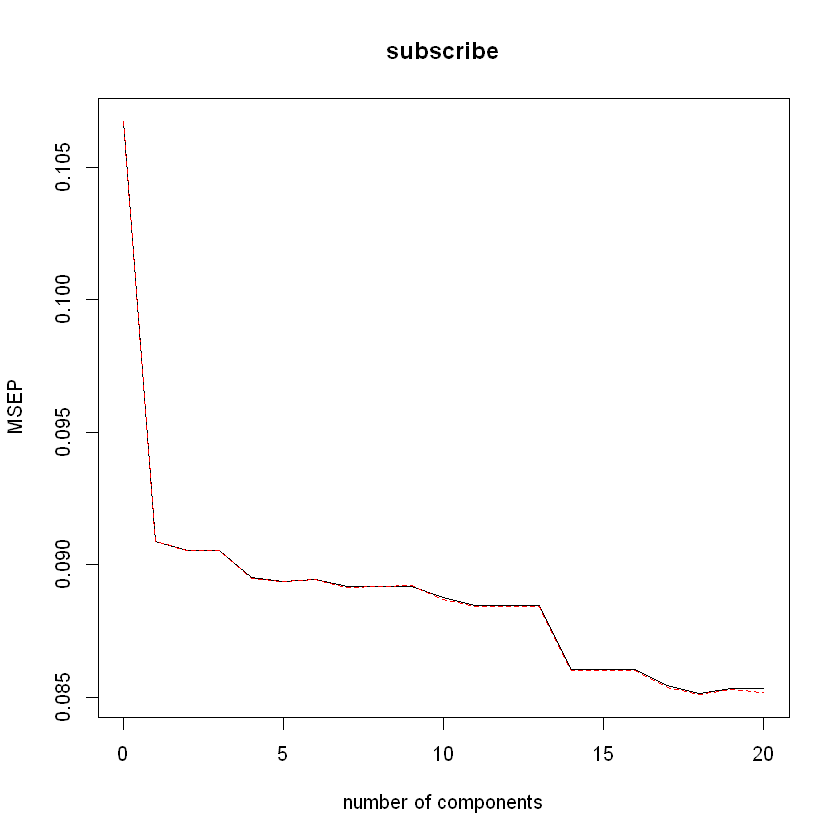

In [65]:
validationplot(pcrm, val.type="MSEP")

In [75]:
pcr_pred <- predict(pcrm, newdata=Test, ncomp=16)

In [76]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=pcr_pred)
write.csv(output, 'C:/Users/cxie/Desktop/pcr_submission_v6.csv', row.names=FALSE)

### 3.7 GAMs

In [78]:
gamm <- gam(subscribe ~., data=Train)

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"

In [79]:
gam_pred <- predict(gamm, newdata=Test)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

In [81]:
# Output predicted file
output <- data.frame(client_id=Test$client_id, subscribe=gam_pred)
write.csv(output, 'C:/Users/cxie/Desktop/gam_submission_v1.csv', row.names=FALSE)